Notebook to create the final list of subjects. Criteria:
- Have reactivity information
- both have stroop and msit
- be low motion for both tasks
- something else? resting as well?

In [1]:
import numpy as np
import pandas as pd
import regex as re
import os 
from tqdm import tqdm
from nilearn import image, input_data
from joblib import Parallel, delayed

In [2]:
# No nans in this dataset for reactivity
pd.read_csv("../data/pip_reactivity_2020.csv").filter(regex="reactivity").isna().any()

sbp_reactivity_both      False
sbp_reactivity_stroop    False
sbp_reactivity_msit      False
dbp_reactivity_both      False
dbp_reactivity_stroop    False
dbp_reactivity_msit      False
map_reactivity_both      False
map_reactivity_stroop    False
map_reactivity_msit      False
hr_reactivity_both       False
hr_reactivity_stroop     False
hr_reactivity_msit       False
dtype: bool

In [3]:
# subjects with reactivity
subjects_reactivity = pd.read_csv("../data/pip_reactivity_2020.csv").id.to_list()

reactivity_df = pd.DataFrame({'SUB_ID': subjects_reactivity})
reactivity_df.head()

,SUB_ID
0,1002
1,1003
2,1004
3,1005
4,1006


In [4]:
atlas_file = "../data/shen_2mm_268_parcellation.nii.gz"

def check_acquisition_task(img_file):
    """
    
    function to check that we have a full acquisition (280 scans) and 
    that nifti masker 
    
    """
    
    masker = input_data.NiftiLabelsMasker(atlas_file)
    roi_data = masker.fit_transform(img_file)
    n_obs = roi_data.shape[0]
    
    full_acq = False
    if n_obs == 280:
        full_acq = True
    
    all_rois = ~np.any(np.all(roi_data == 0, axis=0))
    is_ok = (full_acq==True) & (all_rois==True)
    
    return is_ok

def check_acquisition_rest(img_file):
    """
    
    function to check that we have a full acquisition (280 scans) and 
    that nifti masker 
    
    """
    
    masker = input_data.NiftiLabelsMasker(atlas_file)
    roi_data = masker.fit_transform(img_file)
    n_obs = roi_data.shape[0]
    
    full_acq = False
    if n_obs == 150:
        full_acq = True
    
    all_rois = ~np.any(np.all(roi_data == 0, axis=0))
    is_ok = (full_acq==True) & (all_rois==True)
    
    return is_ok

In [5]:
task_id = "stroop"
pattern = "sub-(.*)_ses-01_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % task_id
pattern_confounders = "../task-%s" % task_id + "/confounders/sub-%s" + "_ses-01_task-%s_desc-confounds_regressors.tsv" % task_id
list_subjects_ids = []
list_subjects_fwd = []

for filename in tqdm(os.listdir("../task-%s/preproc" % task_id)):
    subj = re.findall(pattern=pattern, string=filename)[0]

    list_subjects_ids.append(int(subj))
    
    fwd = pd.read_csv(pattern_confounders % subj, sep="\t").framewise_displacement.dropna().mean()
    list_subjects_fwd.append(fwd)
    
stroop_df = pd.DataFrame({'SUB_ID': list_subjects_ids, 'FWD': list_subjects_fwd})
stroop_df.head()

parallel = Parallel(n_jobs=-1)
is_ok = parallel(delayed(check_acquisition_task)("../task-%s/preproc" % task_id + "/" + filename) \
                     for filename in tqdm(os.listdir("../task-%s/preproc" % task_id)))
is_ok = np.array(is_ok)

stroop_df = stroop_df.loc[is_ok,:]

100%|██████████| 333/333 [03:48<00:00,  1.46it/s]


In [11]:
stroop_df.shape

(332, 2)

In [6]:
task_id = "msit"
pattern = "sub-(.*)_ses-01_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % task_id
pattern_confounders = "../task-%s" % task_id + "/confounders/sub-%s" + "_ses-01_task-%s_desc-confounds_regressors.tsv" % task_id
list_subjects_ids = []
list_subjects_fwd = []

for filename in tqdm(os.listdir("../task-%s/preproc" % task_id)):
    subj = re.findall(pattern=pattern, string=filename)[0]
    
    list_subjects_ids.append(int(subj))
    
    fwd = pd.read_csv(pattern_confounders % subj, sep="\t").framewise_displacement.dropna().mean()
    list_subjects_fwd.append(fwd)

msit_df = pd.DataFrame({'SUB_ID': list_subjects_ids, 'FWD': list_subjects_fwd})
msit_df.head()

parallel = Parallel(n_jobs=10)

parallel = Parallel(n_jobs=-1)
is_ok = parallel(delayed(check_acquisition_task)("../task-%s/preproc" % task_id + "/" + filename) \
                     for filename in tqdm(os.listdir("../task-%s/preproc" % task_id)))
is_ok = np.array(is_ok)

msit_df = msit_df.loc[is_ok,:]

100%|██████████| 335/335 [03:31<00:00,  1.58it/s]


In [9]:
msit_df.shape

(334, 2)

In [66]:
task_id = "msit"
pattern = "sub-(.*)_ses-01_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % task_id
pattern_confounders = "../task-%s" % task_id + "/confounders/sub-%s" + "_ses-01_task-%s_desc-confounds_regressors.tsv" % task_id
list_subjects_ids = []
list_subjects_fwd = []
for filename in os.listdir("../task-%s/preproc" % task_id):
    subj = re.findall(pattern=pattern, string=filename)[0]
    list_subjects_ids.append(int(subj))
    
    fwd = pd.read_csv(pattern_confounders % subj, sep="\t").framewise_displacement.dropna().mean()
    list_subjects_fwd.append(fwd)
    
msit_df = pd.DataFrame({'SUB_ID': list_subjects_ids, 'FWD': list_subjects_fwd})
msit_df.head()

,SUB_ID,FWD
0,5317,0.182166
1,3149,0.226422
2,2124,0.227824
3,325,0.158878
4,7607,0.213771


In [8]:
task_id = "rest"
pattern = "sub-(.*)_ses-01_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % task_id
pattern_confounders = "../task-%s" % task_id + "/confounders/sub-%s" + "_ses-01_task-%s_desc-confounds_regressors.tsv" % task_id
list_subjects_ids = []
list_subjects_fwd = []

for filename in tqdm(os.listdir("../task-%s/preproc" % task_id)):
    subj = re.findall(pattern=pattern, string=filename)[0]
    
    list_subjects_ids.append(int(subj))
    
    fwd = pd.read_csv(pattern_confounders % subj, sep="\t").framewise_displacement.dropna().mean()
    list_subjects_fwd.append(fwd)
    
resting_df = pd.DataFrame({'SUB_ID': list_subjects_ids, 'FWD': list_subjects_fwd})
resting_df.head()

parallel = Parallel(n_jobs=10)

parallel = Parallel(n_jobs=-1)
is_ok = parallel(delayed(check_acquisition_restt)("../task-%s/preproc" % task_id + "/" + filename) \
                     for filename in tqdm(os.listdir("../task-%s/preproc" % task_id)))
is_ok = np.array(is_ok)

resting_df = resting_df.loc[is_ok,:]

100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


In [13]:
resting_df.shape

(333, 2)

Find intersection amonng subjects and save it to disk for further use for several thresholds

In [14]:
for motion_thr in [0.3, 0.35, 0.4]:
    stroop_low_motion_df = stroop_df[stroop_df.FWD < motion_thr]
    msit_low_motion_df = msit_df[msit_df.FWD < motion_thr]
    resting_low_motion_df = resting_df[resting_df.FWD < motion_thr]

    subjects_intersect = list(set(reactivity_df.SUB_ID.to_list()) & \
                               set(stroop_low_motion_df.SUB_ID.to_list()) & \
                               set(msit_low_motion_df.SUB_ID.to_list()) & \
                               set(resting_low_motion_df.SUB_ID.to_list())
                              )
    
    print(len(subjects_intersect))

    np.savetxt("../data/subjects_intersect_motion_%s.txt" % str(motion_thr*100).split(".")[0].zfill(3),  
               subjects_intersect, fmt="%d")

229
259
267


In [15]:
# The same but with a more stringet threshold on resting (0.2)
for motion_thr in [0.3, 0.35, 0.4]:
    stroop_low_motion_df = stroop_df[stroop_df.FWD < motion_thr]
    msit_low_motion_df = msit_df[msit_df.FWD < motion_thr]
    resting_low_motion_df = resting_df[resting_df.FWD < 0.2]

    subjects_intersect = list(set(reactivity_df.SUB_ID.to_list()) & \
                               set(stroop_low_motion_df.SUB_ID.to_list()) & \
                               set(msit_low_motion_df.SUB_ID.to_list()) & \
                               set(resting_low_motion_df.SUB_ID.to_list())
                              )
    print(len(subjects_intersect))
    np.savetxt("../data/subjects_intersect_motion_%s_rest_020.txt" % str(motion_thr*100).split(".")[0].zfill(3),  
               subjects_intersect, fmt="%d")

188
195
198


In [14]:
from cofluctuate_bold_glm.utils import create_task_confounders

In [15]:
run_img = "../task-stroop/preproc/sub-1002_ses-01_task-stroop_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
events = "../data/task-stroop_events.tsv"
events = pd.read_csv("../data/task-stroop_events.tsv", sep="\t")
events # create_task_confounders()

,onset,duration,trial_type
0,10,60,Incongruent
1,80,60,Congruent
2,150,60,Incongruent
3,220,60,Congruent
4,290,60,Incongruent
5,360,60,Congruent
6,430,60,Incongruent
7,500,60,Congruent


In [17]:
conf_df = pd.read_csv("../task-stroop/confounders/sub-1002_ses-01_task-stroop_desc-confounds_regressors.tsv", sep="\t")
conf_df = conf_df.filter(regex="rot_[x-z]$|trans_[x-z]$")


In [21]:
clean

<function nilearn.signal.clean(signals, sessions=None, detrend=True, standardize='zscore', confounds=None, standardize_confounds=True, low_pass=None, high_pass=None, t_r=2.5, ensure_finite=False)>

In [22]:
from nilearn.input_data import NiftiLabelsMasker
run_img = "../task-stroop/preproc/sub-1002_ses-01_task-stroop_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
conf_df = pd.read_csv("../task-stroop/confounders/sub-1002_ses-01_task-stroop_desc-confounds_regressors.tsv", sep="\t")
conf_df = conf_df.filter(regex="rot_[x-z]$|trans_[x-z]$")
run_img = image.load_img(run_img)
n_scans = run_img.shape[3]

start_time = 0
end_time = (n_scans - 1)* 2.0
frame_times = np.linspace(start_time, end_time, n_scans)
task_conf = create_task_confounders(frame_times, events, fir_delays=[1,2,3,4,5])

label_masker = NiftiLabelsMasker(labels_img=atlas_file, 
                                 detrend=True,
                                 low_pass = None,
                                 high_pass = 1/187.,
                                 t_r = 2.0, 
                                 standardize=False)

atlas_ts_conf = label_masker.fit_transform(run_img, confounds=conf_df)
conf_clean = clean(conf_df.to_numpy(), detrend=True, high_pass= 1/187., t_r=2, standardize=False)

[np.corrcoef(conf_clean[:,0], x)[0,1] for x in atlas_ts_conf.T]

In [28]:
np.abs([[np.corrcoef(conf_clean[:,ii], x)[0,1] for x in atlas_ts_conf.T] for ii in range(conf_clean.shape[1])]).max()

3.731215228223418e-11

In [23]:
np.corrcoef(clean(atlas_ts_conf, confounds=task_conf, standardize_confounds=False, t_r=2.0)[:,0], task_conf[:,4])

array([[ 1.00000000e+00, -7.18158643e-17],
       [-7.18158643e-17,  1.00000000e+00]])

In [114]:
#conf_df = pd.read_csv("../task-stroop/confounders/sub-1002_ses-01_task-stroop_desc-confounds_regressors.tsv", sep="\t")
#conf_df = conf_df.filter(regex="rot_[x-z]$|trans_[x-z]$")
conf_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,0.615510,-0.073622,-1.11149,-0.026077,-0.017888,-0.015497
1,0.600545,-0.073211,-1.08547,-0.025518,-0.017109,-0.015246
2,0.606549,-0.075858,-1.07293,-0.025000,-0.017374,-0.015406
3,0.606759,-0.078552,-1.08695,-0.025306,-0.017479,-0.015501
4,0.595637,-0.084132,-1.08210,-0.025268,-0.017427,-0.015400


In [124]:
from nilearn.signal import butterworth
foo = butterworth(conf_df.to_numpy().copy(), sampling_rate=2.0, high_pass=1/187.)
np.corrcoef(atlas_ts_conf[:,0], foo[:,0])

array([[ 1.        , -0.04658995],
       [-0.04658995,  1.        ]])

In [89]:
label_masker.fit_transform??

Signature: label_masker.fit_transform(imgs, confounds=None)
Docstring:
Prepare and perform signal extraction from regions.

        
Source:   
    def fit_transform(self, imgs, confounds=None):
        """ Prepare and perform signal extraction from regions.

        """
        return self.fit().transform(imgs, confounds=confounds)
File:      ~/anaconda3/lib/python3.8/site-packages/nilearn/input_data/nifti_labels_masker.py
Type:      method


In [245]:
#[np.corrcoef(conf_df.iloc[:,0], x)[0,1] for x in atlas_ts_conf.T]


In [37]:
atlas_ts_conf.shape

(280, 268)

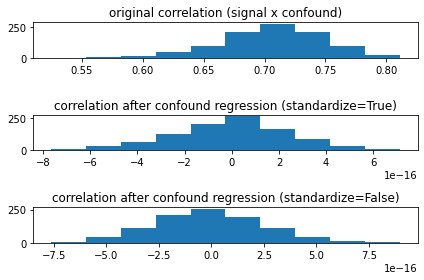

In [231]:
import numpy as np
from nilearn.signal import clean
import matplotlib.pyplot as plt

r=[]
r_w_std=[]
r_no_std=[]
for i in range(1000):
    X=np.random.rand(100,1)
    c = X + np.random.rand(100,1)
    X_w_std = clean(X, detrend=True, standardize=True, standardize_confounds=True, confounds=c)
    # Use standardize_confounds=False to get previous behaviour...
    X_no_std = clean(X, detrend=True, standardize=False, standardize_confounds=False, confounds=c)                                

    r.append(np.corrcoef(X.T,c.T)[1,0])
    r_w_std.append(np.corrcoef(X_w_std.T,c.T)[1,0])
    r_no_std.append(np.corrcoef(X_no_std.T,c.T)[1,0])

f, (ax1, ax2,ax3) = plt.subplots(3)
ax1.hist(r)
ax1.set_title('original correlation (signal x confound)')
ax2.hist(r_w_std)
ax2.set_title('correlation after confound regression (standardize=True)')
ax3.hist(r_no_std)
ax3.set_title('correlation after confound regression (standardize=False)')
plt.tight_layout()
plt.show()

In [244]:
X_w_std = clean(X, detrend = True, standardize=False, high_pass=0.01, confounds=c)
c_clean = clean(c, detrend = True, high_pass=0.01, standardize=False)
#c_clean_2 = my_clean(c, detrend = True, high_pass=0.01, standardize=False)
#c_clean
print(np.corrcoef(X_w_std.T, c_clean.T)[0,1])
#print(np.corrcoef(X_w_std.T, c_clean_2.T)[0,1])

-0.0007162469641231796
